# Stock prediction

- Predecting stock closing price using finance data
- Displaying the data using pandas
- Processing the data with pytorch


In [47]:
import time
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

# This code will check for CUDA, MPS (Apple Silicon), and ROCm (AMD) support
# and set the device accordingly.
# This is important for PyTorch to use the GPU
# if available, otherwise it will default to CPU

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple MPS device")
elif torch.backends.hip.is_available():
    device = torch.device("hip")
    print("Using AMD ROCm device")
else:
    device = torch.device("cpu")
    print("No Useable GPU available, fallback to CPU")

Using CUDA device


# Data frame

Pulls in the data and puts it in a data frame
Displays the closing cost data as a line graph


                 Open       High        Low      Close     Volume
Date                                                             
2020-01-02    5.94402    5.97288    5.89330    5.97288  238675161
2020-01-03    5.85308    5.92105    5.82812    5.87724  206634962
2020-01-06    5.78358    5.90707    5.75741    5.90189  264014644
2020-01-07    5.93024    6.01934    5.88510    5.97338  320543948
2020-01-08    5.96910    6.02601    5.92905    5.98467  278402946
...               ...        ...        ...        ...        ...
2025-05-06  111.48000  114.74000  110.82200  113.54000  158525621
2025-05-07  113.04500  117.68000  112.28180  117.06000  207827821
2025-05-08  118.25000  118.68000  115.85000  117.37000  198428122
2025-05-09  117.35000  118.23000  115.21000  116.65000  132972189
2025-05-12  121.97000  123.00000  120.32000  122.99500  224331228

[1347 rows x 5 columns]


Text(0.5, 0, 'Date')

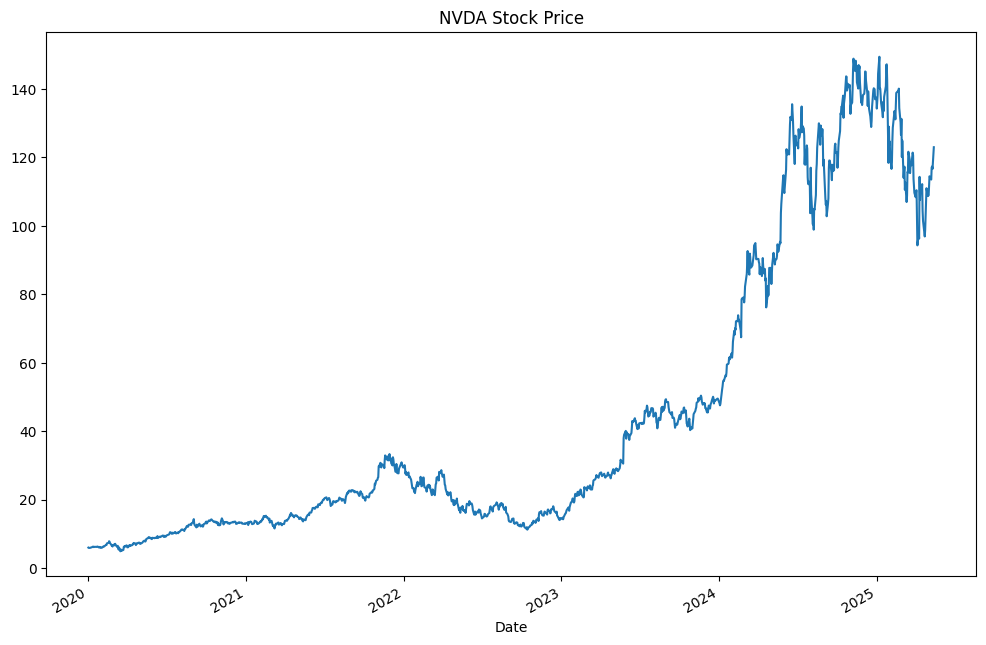

In [48]:
# Enter Ticker to be predicted here.
ticker = 'NVDA'

start = datetime.datetime(2020, 1, 1)
end = datetime.datetime.today()
# end = datetime.datetime(2025, 1, 31)
df = web.DataReader(ticker, 'stooq', start)
df = df.sort_index()
print(df)

df.Close.plot(figsize=(12, 8))
plt.title(f'{ticker} Stock Price')
plt.xlabel('Date')

# Scaler Explainer

Scaler is going to scale the data to fit into a normal distribution with a range of 0 to 1.
compaing past results to predict future movements


In [49]:
scaler = StandardScaler()
df["Close"] = scaler.fit_transform(df[["Close"]])
df.Close

Date
2020-01-02   -0.895120
2020-01-03   -0.897378
2020-01-06   -0.896796
2020-01-07   -0.895108
2020-01-08   -0.894841
                ...   
2025-05-06    1.644631
2025-05-07    1.727742
2025-05-08    1.735061
2025-05-09    1.718061
2025-05-12    1.867872
Name: Close, Length: 1347, dtype: float64

# Sequence Length

range of past data to sample in order to predict the next result
data is dumped into an empty list from a for loop


In [50]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i + seq_length])
data = np.array(data)

# Print the shape and a sample
print("Shape of data:", data.shape)
print("First window:", data[0])
print("Last window:", data[-1])

# Output to see the data and its shape [dimensions]
data

Shape of data: (1317, 30)
First window: [-0.89511953 -0.89737767 -0.89679567 -0.89510773 -0.89484116 -0.89329252
 -0.89252612 -0.88802825 -0.89079119 -0.8917904  -0.88981937 -0.88961207
 -0.89040468 -0.88915921 -0.88751377 -0.88890468 -0.89494977 -0.89038579
 -0.89180693 -0.89165133 -0.89716848 -0.89487185 -0.89087855 -0.88873964
 -0.88670557 -0.88825869 -0.88157328 -0.87867292 -0.87593855 -0.87697365]
Last window: [1.55325735 1.52279936 1.56459056 1.57096549 1.36743998 1.19059473
 1.26921886 1.23758032 1.6632839  1.50367457 1.58300702 1.57781263
 1.61299279 1.43095316 1.36012062 1.25198294 1.29873241 1.38892585
 1.4767582  1.58489589 1.53106315 1.5379103  1.53554921 1.59906239
 1.66729774 1.65124237 1.64463133 1.72774151 1.73506088 1.71806107]


array([[-0.89511953, -0.89737767, -0.89679567, ..., -0.87867292,
        -0.87593855, -0.87697365],
       [-0.89737767, -0.89679567, -0.89510773, ..., -0.87593855,
        -0.87697365, -0.86580808],
       [-0.89679567, -0.89510773, -0.89484116, ..., -0.87697365,
        -0.86580808, -0.86182588],
       ...,
       [ 1.64982572,  1.59481244,  1.55325735, ...,  1.65124237,
         1.64463133,  1.72774151],
       [ 1.59481244,  1.55325735,  1.52279936, ...,  1.64463133,
         1.72774151,  1.73506088],
       [ 1.55325735,  1.52279936,  1.56459056, ...,  1.72774151,
         1.73506088,  1.71806107]], shape=(1317, 30))

# Hidden Layers

A **hidden layer** in a neural network is any layer between the input and output layers. It’s called “hidden” because you don’t directly interact with it—the network learns what happens there.

**How it works:**

- Each hidden layer consists of neurons (nodes) that take inputs, apply weights and biases, and pass the result through an activation function.
- The hidden layers allow the network to learn complex patterns and representations from the data.
- In deep learning, having more hidden layers (a “deep” network) enables the model to learn more abstract features.

**In your LSTM model:**

- The LSTM’s `hidden_dim` parameter controls the size of the hidden state vector (how much information each LSTM cell can store).
- `num_layers` controls how many LSTM layers (hidden layers) are stacked.

**Summary:**  
Hidden layers are where the neural network “thinks”—they transform the input step by step, allowing the network to model complex relationships in your data.


In [51]:
# Reshape data to add an extra dimension
data = data.reshape(data.shape[0], data.shape[1], 1)

# Use the first 80% of the data for training and the last 20% for testing
train_size = int(0.8 * len(data))

# Models
x_train = torch.from_numpy(
    data[:train_size, :-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(
    data[:train_size, -1, :]).type(torch.Tensor).to(device)

# Test Model
x_test = torch.from_numpy(
    data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(
    data[train_size:, -1, :]).type(torch.Tensor).to(device)

In [52]:
class PredictionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=0.1):
        # Initialize the parent class
        super(PredictionModel, self).__init__()

        # Initialize the model parameters
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim,
                            num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize the hidden state(h) and cell state(c)
        h0 = torch.zeros(self.num_layers, x.size(
            0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(
            0), self.hidden_dim, device=device)

        # Forward propagate the LSTM
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out

In [ ]:
# Set criterion for training
# Mean Squared Error Loss, works from the derirviative of the loss function
criterion = nn.MSELoss()

# Create the function model & optimizer for training


def opt_model():
    model = PredictionModel(input_dim=1, hidden_dim=24,
                            num_layers=2, output_dim=1).to(device)
    # Optimizer - lr = learning rate lower = more accurate but slower
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    return model, optimizer


# Data Check
# print("Shape of data (after model definition):", data.shape)
# print("First window (after model definition):", data[0])
# print("Last window (after model definition):", data[-1])

In [54]:
# training loop
runs = 100  # Number of runs
run_times = []  # Store the run times
num_epochs = 1000  # Number of epochs
final_losses = []  # Store the final loss for each run

for j in range(runs):
    model, optimizer = opt_model()
    # Training the model
    for i in range(num_epochs):
        start_time = time.time()
        # Model training
        y_train_pred = model(x_train)
        # Calculate the loss
        loss = criterion(y_train_pred, y_train)
        # Optimization
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # step to the right direction to optimize the loss
    elaspsed = time.time() - start_time
    run_times.append(elaspsed)
    final_losses.append(loss.item())
    print(
        f"Run {j+1}/{runs}, complete | Time: {elaspsed:.3f}s | Final Loss: {loss.item():.6f}")

# Print the final loss for each run
avg_loss = sum(final_losses) / len(final_losses)
total_time = sum(run_times)  # / len(run_times)

print(f"Average time over {runs} runs: {total_time:.4f}s")
print(f"Average loss over {runs} runs: {avg_loss:.8f}")


# Nural Nine original print
# if i % 25 == 0:  # Print the loss every 25 epochs, % means epoch
#            print(i, loss.item())

Run 1/100, complete | Time: 0.001s | Final Loss: 0.000645
Run 2/100, complete | Time: 0.001s | Final Loss: 0.000786
Run 3/100, complete | Time: 0.001s | Final Loss: 0.000675
Run 4/100, complete | Time: 0.003s | Final Loss: 0.000762
Run 5/100, complete | Time: 0.001s | Final Loss: 0.000650
Run 6/100, complete | Time: 0.001s | Final Loss: 0.000722
Run 7/100, complete | Time: 0.001s | Final Loss: 0.000622
Run 8/100, complete | Time: 0.001s | Final Loss: 0.000678
Run 9/100, complete | Time: 0.001s | Final Loss: 0.000711
Run 10/100, complete | Time: 0.003s | Final Loss: 0.000679
Run 11/100, complete | Time: 0.001s | Final Loss: 0.000718
Run 12/100, complete | Time: 0.001s | Final Loss: 0.000663
Run 13/100, complete | Time: 0.001s | Final Loss: 0.000546
Run 14/100, complete | Time: 0.001s | Final Loss: 0.000724
Run 15/100, complete | Time: 0.001s | Final Loss: 0.000676
Run 16/100, complete | Time: 0.001s | Final Loss: 0.000733
Run 17/100, complete | Time: 0.001s | Final Loss: 0.000722
Run 18

In [55]:
# NOTE:
# If you get an error like "AttributeError: 'numpy.ndarray' object has no attribute 'detach'" here,
# it means y_train or y_test is already a NumPy array (not a PyTorch tensor).
# This happens if you run this cell (Cell 18) more than once without first re-running the data prep cell (Cell 13),
# which recreates y_train and y_test as tensors.
#
# To fix:
# - Always re-run Cell 13 before running this cell.
# - OR, add a type check before using .detach(), e.g.:
#     if isinstance(y_test, torch.Tensor):
#         y_test_np = y_test.detach().cpu().numpy()
#     else:
#         y_test_np = y_test
#     y_test = scaler.inverse_transform(y_test_np)
# Do the same for y_train if needed.

model.eval()  # Set the model to evaluation mode
y_test_pred = model(x_test)  # Make predictions

# Reverse the sacling of the data, shift it to the cpu and convert to numpy array

# Training Data
y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())

# Test Data
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())

In [56]:
# Calculate the Root Mean Squared Error (RMSE)
# is more inline with the prices of the stock
train_rmse = root_mean_squared_error(y_train[:, 0], y_train_pred[:, 0])
test_rmse = root_mean_squared_error(y_test[:, 0], y_test_pred[:, 0])
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Train RMSE: 1.0729
Test RMSE: 17.9885


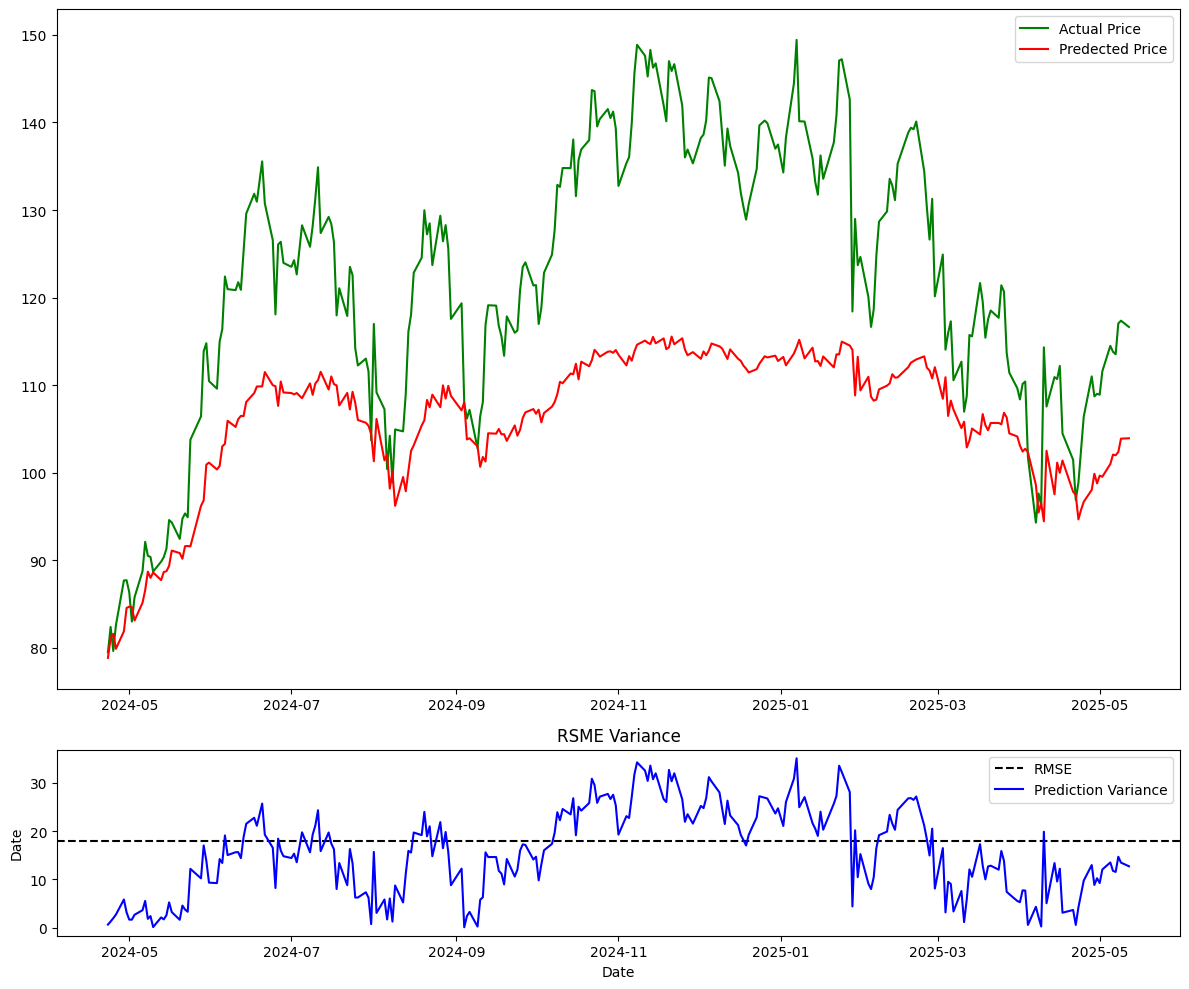

In [57]:
# Plot the Price and Prediction as a line graph
# Below the P & P we plot the error variance from the RSME
test_start = len(df) - len(y_test)
test_index = df.index[-len(y_test):]


fig = plt.figure(figsize=(12, 10))
# Grid specification figure (rows, columns)
gs = fig.add_gridspec(4, 1)


# Axis Specs
ax1 = fig.add_subplot(gs[:3, 0])
ax2 = fig.add_subplot(gs[3, 0])

# After plotting on ax1 and ax2, set major ticks to yearly
# ax1.xaxis.set_major_locator(mdates.YearLocator())
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# ax2.xaxis.set_major_locator(mdates.YearLocator())
# ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


# Give all of the data from the beginning to the end as the date on the x axis.
ax1.plot(df.iloc[-len(y_test):].index, y_test,
         color='green', label='Actual Price')
ax1.plot(df.iloc[-len(y_test):].index, y_test_pred,
         color='red', label='Predected Price')

# ax1.plot(test_index, y_test, color='green', label='Actual Price')
# ax1.plot(test_index, y_test_pred, color='red', label='Price Prediction')
ax1.legend()

plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')


# Plot the RMSE
ax2.axhline(test_rmse, color='black', linestyle='--', label='RMSE')
ax2.plot(test_index, abs(y_test - y_test_pred),
         color='blue', label='Prediction Variance')
ax2.legend()

plt.xlabel('Date')
plt.ylabel('Date')
plt.title('RSME Variance')
plt.tight_layout()
plt.show()